<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Binary subreddit classification with sentiment and topic words analysis  

## Problem Statement

Web streaming service providers must take notice of their customers' direct feedback.Our data team were tasked to build a machine learning classification model to identify and label words, sentences, or paragraphs taken from online discussion posts, chat rooms or comments related to the provider. Sentiment analysis can be done on them and infer data and knowledge for content management or product review.

---
## Contents:
- [Background](#Background)
- [Webscraping](#Webscraping-for-Subreddit-posts)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Preprocessing](#Data-Preprocessing)
- [Modeling Process](#Modeling-Process)
- [Pycaret Auto ML](#Pycaret-auto-ML)
- [Data Visualization](#Data-Visualization)
- [Conclusions and Recommendations](#Conclusion-and-Recommendation)
---

## Background

With all the Online streaming services available, product management can be tedious and tricky matter. The best way to get a estimate gauge on what is likeable and what is not is from user input and feedback. Comments and post are one of the many avenues to gather feedbacks and trending topics. However manualy reading them will take and exhaustive amount of time and money. 

Automation is always the key to normal repeatative task. Therefore a soluition to solve all those concerns is neccesary. 

### DataSet used
* Netlifx posts webscraped from ([*source*](https://www.reddit.com/r/netflix/))
* Disneyplus posts webscraped from  ([*source*](https://www.reddit.com/r/DisneyPlus/))

## Webscraping for Subreddit posts

**Disney plus dataset**

RangeIndex: 34808 entries, 0 to 34807

Data columns (total 3 columns):

i     |Column     |Non-Null Count  |Dtype 
---  |------     |--------------  |----- 
 0   |subreddit  |34808 non-null  |object
 1   |selftext   |22110 non-null  |object
 2   |title      |34808 non-null  |object

**Netflix dataset**

RangeIndex: 50065 entries, 0 to 50064

Data columns (total 3 columns):

 i   |Column     |Non-Null Count  |Dtype 
---  |------     |--------------  |----- 
 0   |subreddit  |50065 non-null  |object
 1   |selftext   |32943 non-null  |object
 2   |title      |50065 non-null  |object

In [1]:
# imports for webscraping
import requests
import pandas as pd
import time

In [2]:
from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

In [4]:
def scrape_post(utc,reddit,Max):
    st = time.time()
    temp_post = []
    count = 0
    
    while len(temp_post) <Max:
        url =  'https://api.pushshift.io/reddit/search/submission'
        params = {'subreddit':reddit,
                  'size' : 100,
                  'before': utc }
        res = requests.get(url,params)
        posts = res.json()['data']
        utc = posts[len(posts)-1]['created_utc']
        temp_post = temp_post + posts
        data_df = pd.DataFrame(temp_post)
        temp_df = data_df[['subreddit','selftext','title','created_utc']]
        et = time.time()
        count +=1
        if count in[*range(50,501,10)]:
            print(f'{count} out of {500}, {(et-st)/60:0.0f}min')
    return temp_df

In [ ]:
# scraping for posts
netflix_df = scrape_post(1664501080,'Netflix',50000)
disneyplus_df = scrape_post(1664503429,'DisneyPlus',50000)

## Data Cleaning

In [2]:
# import modules
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

import re
import contractions
import emoji
from nltk.stem import WordNetLemmatizer
import nlpaug
import nlpaug.augmenter.word as naw
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

- *Step1- checking dataframe structure*

In [3]:
# simulation after web scraping
netflix_df = pd.read_csv('netflix.csv')
disneyplus_df = pd.read_csv('disneyplus.csv')

In [4]:
print(disneyplus_df.shape)
print(disneyplus_df.info())
disneyplus_df.head()

(34808, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34808 entries, 0 to 34807
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  34808 non-null  object
 1   selftext   22110 non-null  object
 2   title      34808 non-null  object
dtypes: object(3)
memory usage: 815.9+ KB
None


,subreddit,selftext,title
0,DisneyPlus,NaN,Marvel’s Iron Wars to Be Movie As Don Cheadle ...
1,DisneyPlus,If I start something on my laptop screen it wi...,Green Screen/Not streaming on second monitor :...
2,DisneyPlus,I’m completely baffled. Tonight my wife and I ...,"Can someone please, in the simplest of terms, ..."
3,DisneyPlus,"Hi, question about Ford v Ferrari in the US. A...",Ford v Ferrari
4,DisneyPlus,I wanted to see how much it would be to get th...,account management issue


In [5]:
print(netflix_df.shape)
print(netflix_df.info())
netflix_df.head()

(50065, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50065 entries, 0 to 50064
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  50065 non-null  object
 1   selftext   32943 non-null  object
 2   title      50065 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB
None


,subreddit,selftext,title
0,netflix,Redmi note 11 Pro+ global version. Colors are ...,Netflix colors washed out on HDR mobile app
1,netflix,[removed],Is it just me or is the Dahmer actor like the ...
2,netflix,I’m running out of shows to watch as I’m waiti...,Thriller movie recommendations
3,netflix,[removed],Viewcount 🫵🏻
4,netflix,NaN,'Dahmer' becomes #1 series on Netflix despite ...


In [6]:
# Concatenate both subreddit post into one dataframe
post_df = pd.concat([netflix_df,disneyplus_df])
post_df.shape

(84873, 3)

- *Step2- Duplicated Rows*

In [7]:
post_df[post_df.duplicated(keep='first')] 

,subreddit,selftext,title
19,netflix,[removed],Most SDR content is overcompressed. They use a...
23,netflix,NaN,'Dahmer' becomes #1 series on Netflix despite ...
33,netflix,NaN,MyCleanPC 1.12.2 Crack (100% Working) License ...
177,netflix,NaN,NTLite 2.3.8.8920 Crack License Key [2022-Late...
241,netflix,[removed],Best Romantic Korean Dramas on Netflix Right Now
...,...,...,...
34136,DisneyPlus,[removed],I'm from Mexico.. Can I sign up for Disney+ an...
34146,DisneyPlus,[removed],Error Code 83
34151,DisneyPlus,[removed],Continue watching
34280,DisneyPlus,[removed],Share Disney Plus


- *Step3- Nan values*

In [8]:
post_df.isna().sum()

subreddit        0
selftext     29820
title            0
dtype: int64

- *Step4- drop duplicates & Nan values*

In [9]:
post_df.dropna(inplace = True) # drop all NA

post_df.drop_duplicates(keep='first',inplace = True)# drop duplicated

post_df = post_df.drop(post_df[post_df['selftext'] == '[removed]'].index)# drop selftext with [removed]

post_df = post_df.drop(post_df[post_df['selftext'] == '[deleted]'].index)# drop selftext with [deleted]

post_df.reset_index(inplace = True, drop = True)# reset index

post_df.groupby(['subreddit']).count()# check split count

,selftext,title
subreddit,,
DisneyPlus,7313,7313
netflix,12910,12910


## Exploratory Data Analysis

In [10]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [11]:
# Getting the most frequent words for Netflix and Disney plus
d0 = post_df.loc[post_df['subreddit']=='netflix', 'selftext'].str.lower()
d1 = post_df.loc[post_df['subreddit']=='DisneyPlus', 'selftext'].str.lower()

d0 = pd.Series([contractions.fix(word) for word in d0]).replace({"\d+" : "", "\W+" : " ",'[_]':' '},regex =True ).tolist()
d1 = pd.Series([contractions.fix(word) for word in d1]).replace({"\d+" : "", "\W+" : " ",'[_]':' '},regex =True ).tolist()

In [12]:
stop_words = list(CountVectorizer(stop_words='english').get_stop_words())
eda_stopwords = stop_words + ['just','watch','like','https','com','www']

### Getting top 20 words(Netflix)
Top 20 words includes the subreddit name itself, will be removed for modeling

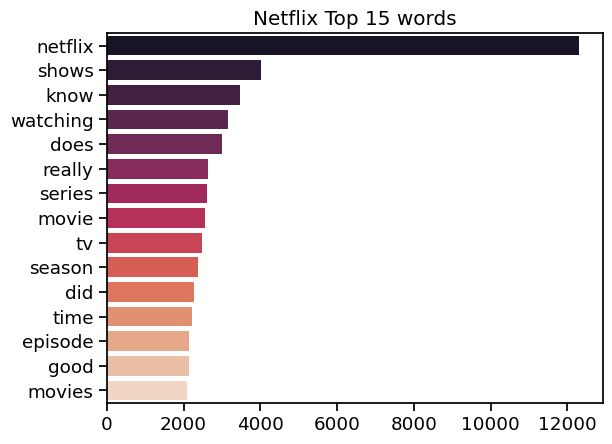

In [13]:
netflix_words_cvec = CountVectorizer(stop_words = eda_stopwords,ngram_range=(1, 1))
netflix_words_tfm = netflix_words_cvec.fit_transform(d0)
netflix_words_tfm = pd.DataFrame(netflix_words_tfm.toarray(), columns=netflix_words_cvec.get_feature_names_out())
netflixtop_15_words = netflix_words_tfm.sum().sort_values(ascending=False).head(15)
sns.barplot(x = netflixtop_15_words.values,
            y = netflixtop_15_words.index,
            palette = "rocket")
plt.title('Netflix Top 15 words');

### Getting top 20 words(DisneyPlus)
Top 20 words includes the subreddit name itself, will be removed for modeling

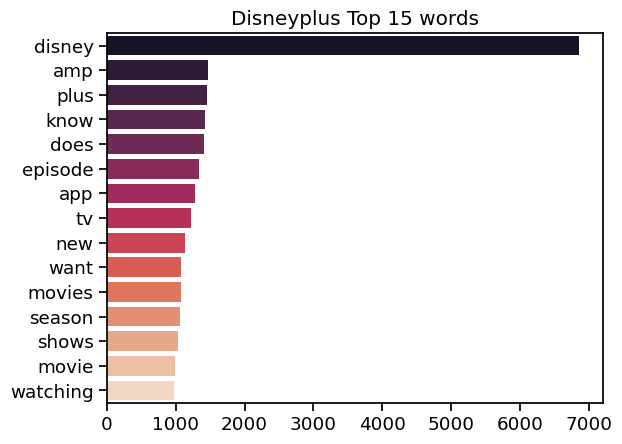

In [14]:
disneyplus_words_cvec = CountVectorizer(stop_words = eda_stopwords,ngram_range=(1, 1))
disneyplus_words_tfm = disneyplus_words_cvec.fit_transform(d1)
disneyplus_words_tfm = pd.DataFrame(disneyplus_words_tfm.toarray(), columns=disneyplus_words_cvec.get_feature_names_out())
disneyplus_top_15_words = disneyplus_words_tfm.sum().sort_values(ascending=False).head(15)
sns.barplot(x = disneyplus_top_15_words.values,
            y = disneyplus_top_15_words.index,
            palette = "rocket")
plt.title('Disneyplus Top 15 words');

### Getting top 20 Biwords(Netflix)
Top 20 biwords will give unique words to related subreddit

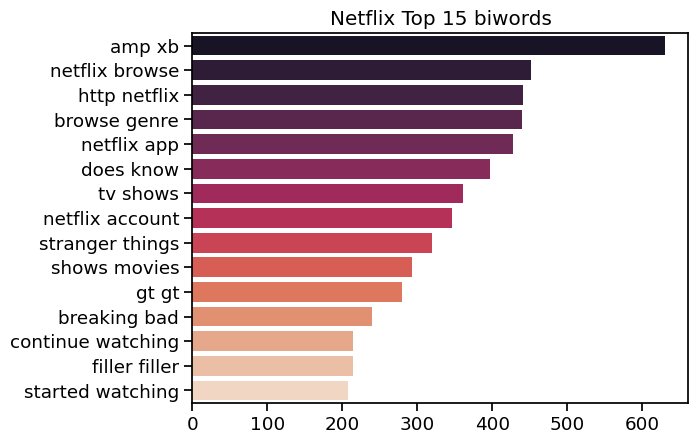

In [15]:
netflix_biwords_cvec = CountVectorizer(stop_words = eda_stopwords,ngram_range=(2, 2))
netflix_biwords_tfm = netflix_biwords_cvec.fit_transform(d0)
netflix_biwords_tfm = pd.DataFrame(netflix_biwords_tfm.toarray(), columns=netflix_biwords_cvec.get_feature_names_out())
netflixtop_15_biwords = netflix_biwords_tfm.sum().sort_values(ascending=False).head(15)
sns.barplot(x = netflixtop_15_biwords.values,
            y = netflixtop_15_biwords.index,
            palette = "rocket")
plt.title('Netflix Top 15 biwords');

### Getting top 20 Biwords(DisneyPlus)
Top 20 biwords will give unique words to related subreddit

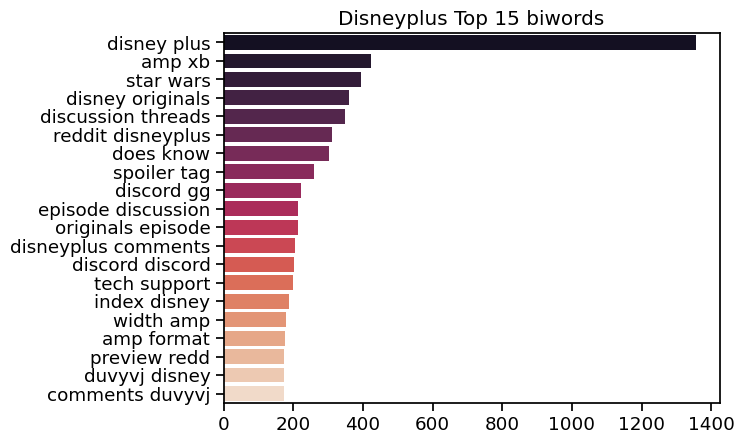

In [16]:
disneyplus_biwords_cvec = CountVectorizer(stop_words = eda_stopwords,ngram_range=(2, 2))
disneyplus_biwords_tfm = disneyplus_biwords_cvec.fit_transform(d1)
disneyplus_biwords_tfm = pd.DataFrame(disneyplus_biwords_tfm.toarray(), columns=disneyplus_biwords_cvec.get_feature_names_out())
disneyplus_top_15_biwords = disneyplus_biwords_tfm.sum().sort_values(ascending=False).head(20)
sns.barplot(x = disneyplus_top_15_biwords.values,
            y = disneyplus_top_15_biwords.index,
            palette = "rocket")
plt.title('Disneyplus Top 15 biwords');

### Frequency distribution plot for lenth of post
Checking variance of post length

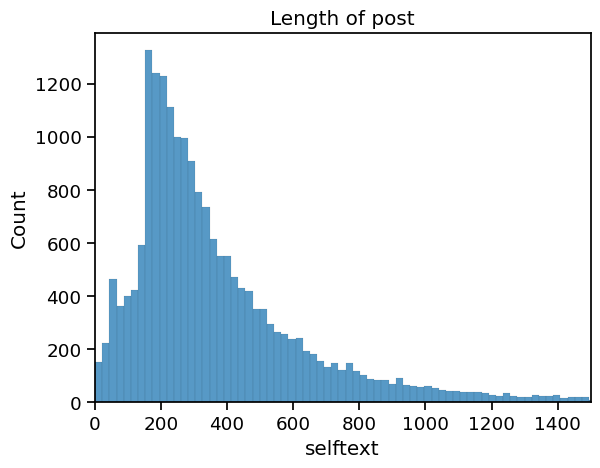

In [17]:
g = sns.histplot(post_df['selftext'].apply(len))
g.set_xlim([0,1500])
plt.title('Length of post');

### Frequency distribution plot for word count of post
Checking variance of post word count

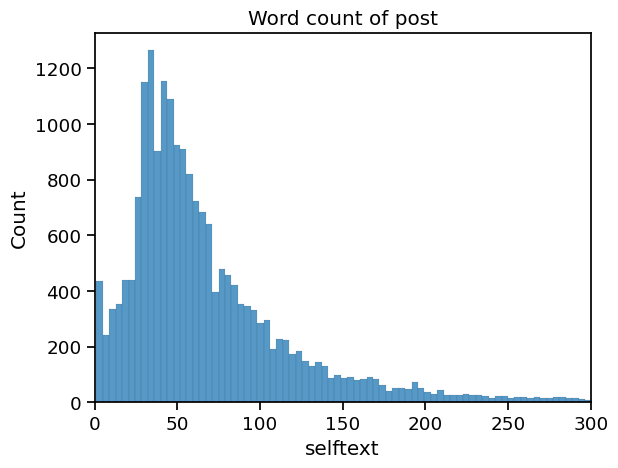

In [18]:
g2 = sns.histplot(post_df['selftext'].apply(str.split).apply(len))
g2.set_xlim([0,300])
plt.title('Word count of post');

## Data Preprocessing

In [19]:
#update stopwords to include url, name of subreddit and high freq words with no meaning
more_stopwords = ['https','http','com','www','png','haa','netflix','disney','disneyplus','plus','wa','ha']
New_stopwords = list(CountVectorizer(stop_words='english').get_stop_words()) + more_stopwords

- Lemmatization is to remove inflectional endings only and to return the base or dictionary form of a word
- Lemmatization was choosen instead of stemming was due to mainly due to the end usage for topic extraction and sentiment analysis

In [20]:
# Instansiate WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function for demojize emoji
def demojize(row):
    temp_lis=[]
    row = row.split()
    for word in row:
        temp_lis.append(emoji.demojize(word))
    temp_lis = ' '.join(temp_lis)
    return temp_lis 

# Function for lemmatizer
def lemma(row):
    temp_lis=[]
    row = row.split()
    for word in row:
        temp_lis.append(lemmatizer.lemmatize(word))
    temp_lis = ' '.join(temp_lis)
    return temp_lis 

- *Step1- lowercase and demojize emojis*

In [21]:
post_df['selftext'] = post_df['selftext'].str.lower().apply(lambda row: demojize(row))
post_df['title'] = post_df['title'].str.lower().apply(lambda row: demojize(row))

- *Step2- apply contractions for words in sentence*

In [22]:
post_df['selftext'] = pd.Series([contractions.fix(word) for word in post_df['selftext']])
post_df['title'] = pd.Series([contractions.fix(word) for word in post_df['title']])

- *Step3- apply regex to only keep words in the sentence*

In [23]:
post_df['selftext'] = post_df['selftext'].replace({"\d+" : "", "\W+" : " ",'[_]':''},regex =True )
post_df['title'] = post_df['title'].replace({"\d+" : "", "\W+" : " ",'[_]':''},regex =True )

- *Step4- apply lemmatizer for words in sentence*

In [24]:
post_df['selftext'] = post_df['selftext'].apply(lambda row: lemma(row))
post_df['title'] = post_df['title'].apply(lambda row: lemma(row))

- *Step5- drop rows with no text after preprocessing*

In [25]:
post_df = post_df.drop(post_df[post_df['selftext'] == ''].index)

## Model

- Accuracy will be uses the metric to compare the models and also judge how well it can predict TP & NP 
- Secondary metrics wll be F1 to judge model precision and recall scores

In [33]:
# Import modules for Modeling
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import NMF

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
from sklearn.metrics import get_scorer

from lightgbm import LGBMClassifier

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam,Adamax

from transformers import pipeline

In [24]:
# Train/Test split for Modeling
X = post_df['selftext']
y = post_df['subreddit'].replace({'netflix': 0 ,'DisneyPlus': 1} )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
y.value_counts(normalize=True)

0    0.638712
1    0.361288
Name: subreddit, dtype: float64

In [42]:
test_stopwords = ['i', 'have', 'been', 'without', 'any', 'until', 'the', 'it', 'keep', 'on','and', 'will', 'not']
aug_test = naw.SynonymAug(aug_src='wordnet',aug_max=None,stopwords=test_stopwords)
#Test out
review = 'i have been watching squid game without any problem until the eighth episode it keep on loading and will not play'
aug.augment(review,n=5)

['i have been watching squid plot without any trouble until the 8th instalment it keep on shipment and will not spiel',
 'i have been check squid plot without any trouble until the 8th episode it keep on load and will not act as',
 'i have been watching squid plot without any trouble until the 8th sequence it keep on load and will not toy',
 'i have been watching squid secret plan without any job until the 8th sequence it keep on shipment and will not toy',
 'i have been view squid secret plan without any trouble until the 8th installment it keep on loading and will not bring']

- Base on assumption that the semantic words of the sentence will have more variance related to the subreddit 
- Therefore, when being tested with new words the model will more likely recognize them

In [ ]:
# Instantiate for word augmentation
aug = naw.SynonymAug(aug_src='wordnet',aug_max=None,stopwords=New_stopwords)

# Word synonyms augmentation
X_train_aug5 = pd.Series([aug.augment(sent,n=5) for sent in tqdm(X_train, desc = 'tqdm() Progress Bar',mininterval =1)], 
                         index = X_train.index,name='selftext')# add five similar sentence
X_train_aug2 = pd.Series([aug.augment(sent,n=2) for sent in tqdm(X_train, desc = 'tqdm() Progress Bar',mininterval =1)], 
                         index = X_train.index,name='selftext')# add two similar sentence

tqdm() Progress Bar:   0%|          | 0/15158 [00:00<?, ?it/s]

tqdm() Progress Bar:   0%|          | 0/15158 [00:00<?, ?it/s]

In [92]:
# Function for displaying scores
def display_scores(model,X_train,y_train,X_test,y_test):
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['netflix', 'DisneyPlus'])
    disp.plot();

    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot();
    
    tn, fp, fn, tp = cm.ravel()
    print(f'Accuracy_score(train):{model.score(X_train,y_train):0.2f}')
    print(f'Accuracy_score(test):{(tp+tn)/(tp+fn+fp+tn):0.2f}')
    print(f'MisclassificationRate_score(test):{1-((tp+tn)/(tp+fn+fp+tn)):0.2f}')
    print(f'Recall_score(test):{tp/(fn+tp):0.2f}') 
    print(f'Specificity_score(test):{tn/(fp+tn):0.2f}') 
    print(f'Precision_score(test):{tp/(tp+fp):0.2f}') 
    print(f'F1_score(test):{f1_score(y_test, model.predict(X_test)):0.2f}')
    print(f'ROC_AUC_score(test):{roc_auc:0.2f}')

#### Baseline Model Naive Bayes Model + Count Vectorizer with normal text, Augmented Synonym text 1, Augmented Synonym text 2

***Normal self text***

In [66]:
%%time
pipe_cvec_NB = Pipeline([
                        ('cvec', CountVectorizer()), 
                        ('nb', MultinomialNB()) 
                        ])

pipe_cvec_NB_params = {
    'cvec__max_features': [30_000,40_000,50_000], # checking for Max features
    'cvec__min_df': [2, 3], # checking for min_df
    'cvec__max_df': [.9, .95], # checking for Max_df
    'cvec__ngram_range': [(1,1),(1,2)], # checking for ngram
    'cvec__stop_words' : [New_stopwords], # checking for Max features
    'nb__fit_prior': [True,False] # checking whether to learn class prior probabilities or not
    }

gs1 = GridSearchCV(pipe_cvec_NB, 
                  param_grid=pipe_cvec_NB_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=10,
                  scoring = 'f1'
                 ).fit(X_train, y_train)

pd.DataFrame(gs1.cv_results_)[['param_cvec__max_df', 'param_cvec__max_features', 'param_cvec__min_df',
                               'param_cvec__ngram_range', 'param_nb__fit_prior','mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: total: 2.88 s
Wall time: 41.2 s


,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_nb__fit_prior,mean_test_score,rank_test_score
23,0.9,50000,3,"(1, 2)",False,0.711571,1
39,0.95,40000,3,"(1, 2)",False,0.711571,1


Accuracy_score(train):0.83
Accuracy_score(test):0.81
MisclassificationRate_score(test):0.19
Recall_score(test):0.67
Specificity_score(test):0.89
Precision_score(test):0.77
F1_score(test):0.71
ROC_AUC_score(test):0.78


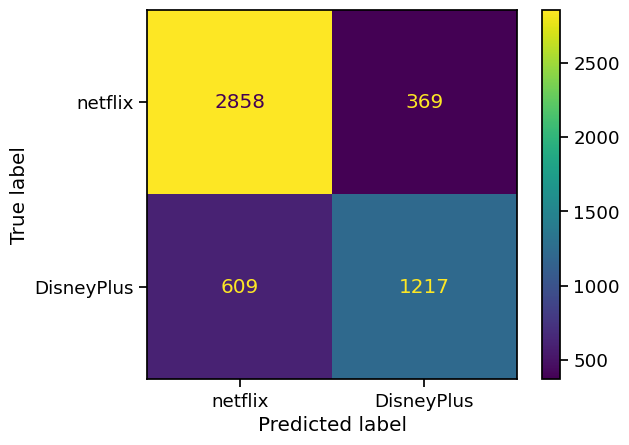

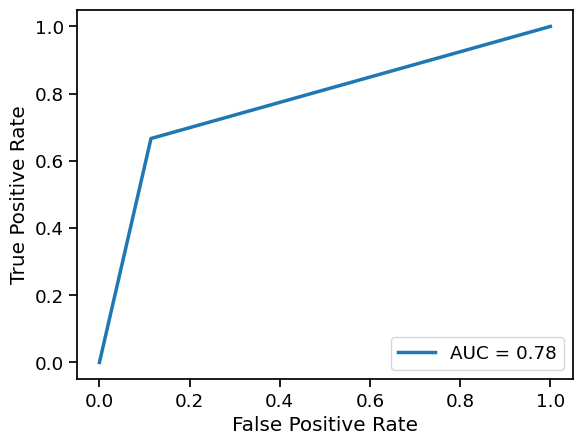

In [67]:
display_scores(gs1,X_train,y_train,X_test,y_test)

***Augmented(1) self text***

In [68]:
X_train_aug2_df = pd.DataFrame(X_train_aug2,index =X_train_aug2.index)
X_train_aug2_df = pd.DataFrame([' '.join(lis) for lis in X_train_aug2],index =X_train_aug2.index,columns =['selftext'])
X_train_aug2_df = pd.Series([' '.join(lis) for lis in X_train_aug2],index =X_train_aug2.index,name ='selftext')
X_train_aug2_df = pd.Series([contractions.fix(word) for word in X_train_aug2_df],index =X_train_aug2.index,name ='selftext').replace({"\d+" : "", "\W+" : " ",'[_]':' '},regex =True )

In [69]:
%%time
pipe_cvec_NB_Aug1 = Pipeline([
                        ('cvec', CountVectorizer()),
                        ('nb', MultinomialNB())
                        ])

pipe_cvec_NB_Aug1_params = {
    'cvec__lowercase':[False],
    'cvec__max_features': [30_000,40_000,50_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.95, .99],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words' : [New_stopwords],
    'nb__fit_prior': [True,False]
    }

gs1aug1 = GridSearchCV(pipe_cvec_NB_Aug1, 
                  param_grid=pipe_cvec_NB_Aug1_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=10,
                  scoring = 'f1'
                 ).fit(X_train_aug2_df, y_train)

pd.DataFrame(gs1aug1.cv_results_)[['param_cvec__max_df', 'param_cvec__max_features', 'param_cvec__min_df',
                               'param_cvec__ngram_range', 'param_nb__fit_prior','mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: total: 5.83 s
Wall time: 1min 30s


,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_nb__fit_prior,mean_test_score,rank_test_score
37,0.99,40000,2,"(1, 1)",False,0.697201,1
45,0.99,50000,2,"(1, 1)",False,0.697201,1


Accuracy_score(train):0.78
Accuracy_score(test):0.78
MisclassificationRate_score(test):0.22
Recall_score(test):0.73
Specificity_score(test):0.82
Precision_score(test):0.69
F1_score(test):0.71
ROC_AUC_score(test):0.77


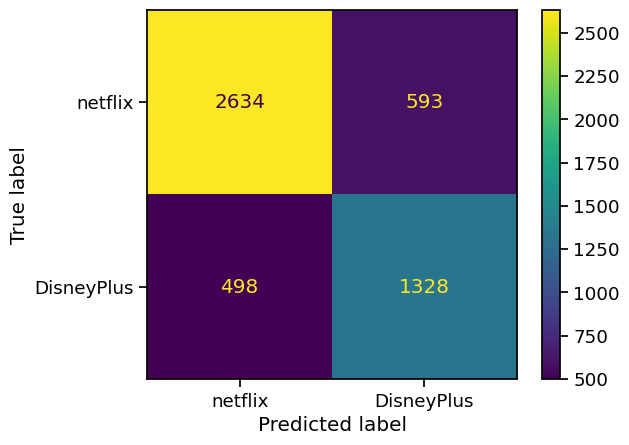

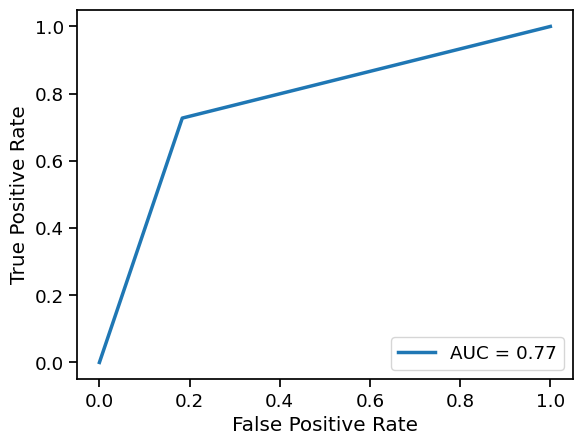

In [70]:
display_scores(gs1aug1,X_train_aug2_df,y_train,X_test,y_test)

***Augmented(2) self text***

In [71]:
X_train_aug5_df = pd.DataFrame(X_train_aug5,index =X_train_aug5.index)
X_train_aug5_df = pd.DataFrame([' '.join(lis) for lis in X_train_aug5],index =X_train_aug5.index,columns =['selftext'])
X_train_aug5_df = pd.Series([' '.join(lis) for lis in X_train_aug5],index =X_train_aug5.index,name ='selftext')
X_train_aug5_df = pd.Series([contractions.fix(word) for word in X_train_aug5_df],index = X_train_aug5.index,name ='selftext').replace({"\d+" : "", "\W+" : " ",'[_]':' '},regex =True )

In [72]:
%%time
pipe_cvec_NB_Aug2 = Pipeline([
                        ('cvec', CountVectorizer()),
                        ('nb', MultinomialNB())
                        ])

pipe_cvec_NB_Aug2_params = {
    'cvec__lowercase':[False],
    'cvec__max_features': [30_000,40_000,50_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words' : [New_stopwords],
    'nb__fit_prior': [True,False]
    }

gs1aug2 = GridSearchCV(pipe_cvec_NB_Aug2, 
                  param_grid=pipe_cvec_NB_Aug2_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=10,
                  scoring = 'f1'
                 ).fit(X_train_aug5_df, y_train)

pd.DataFrame(gs1aug2.cv_results_)[['param_cvec__max_df', 'param_cvec__max_features', 'param_cvec__min_df',
                               'param_cvec__ngram_range', 'param_nb__fit_prior','mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\zuans\.conda\envs\dsi-sg\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\zuans\.conda\envs\dsi-sg\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\zuans\.conda\envs\dsi-sg\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\zuans\.conda\envs\dsi-sg\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cac

CPU times: total: 17.2 s
Wall time: 3min 23s


,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_nb__fit_prior,mean_test_score,rank_test_score
1,0.9,30000,2,"(1, 1)",False,0.708258,1
33,0.95,40000,2,"(1, 1)",False,0.708258,1


Accuracy_score(train):0.78
Accuracy_score(test):0.78
MisclassificationRate_score(test):0.22
Recall_score(test):0.73
Specificity_score(test):0.81
Precision_score(test):0.68
F1_score(test):0.71
ROC_AUC_score(test):0.77


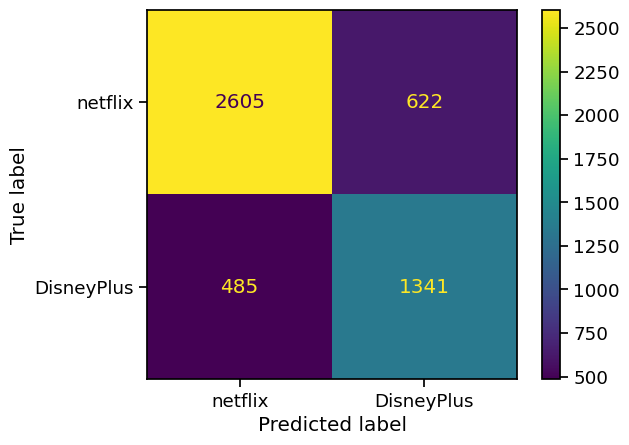

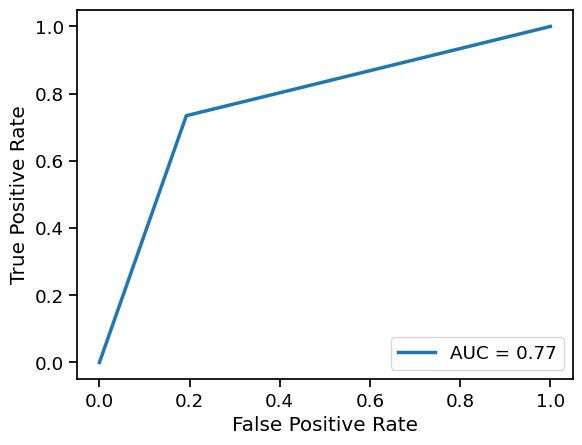

In [73]:
display_scores(gs1aug2,X_train_aug5_df,y_train,X_test,y_test)

#### Model 2 Naive Bayes Model + TFIDF vectorizer with normal text, Augmented text

***Normal self text***

In [74]:
%%time
pipe_tvec = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('nb', MultinomialNB())
                    ])

pipe_tvec_NB_params = {
    'tvec__norm': ['l1','l2'],
    'tvec__max_features': [20_000,30_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words' : [New_stopwords],
    'nb__fit_prior': [True,False],
    
    }

gs2 = GridSearchCV(pipe_tvec, 
                  param_grid=pipe_tvec_NB_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring = 'f1'
                 ).fit(X_train, y_train)

pd.DataFrame(gs2.cv_results_)[['param_tvec__max_df', 'param_tvec__max_features', 'param_tvec__min_df','param_tvec__ngram_range','param_tvec__norm'
                               , 'param_nb__fit_prior','mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: total: 8.5 s
Wall time: 44.3 s


,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__norm,param_nb__fit_prior,mean_test_score,rank_test_score
37,0.9,20000,3,"(1, 1)",l2,False,0.71561,1
61,0.95,30000,3,"(1, 1)",l2,False,0.71561,1


Accuracy_score(train):0.79
Accuracy_score(test):0.80
MisclassificationRate_score(test):0.20
Recall_score(test):0.71
Specificity_score(test):0.85
Precision_score(test):0.73
F1_score(test):0.72
ROC_AUC_score(test):0.78


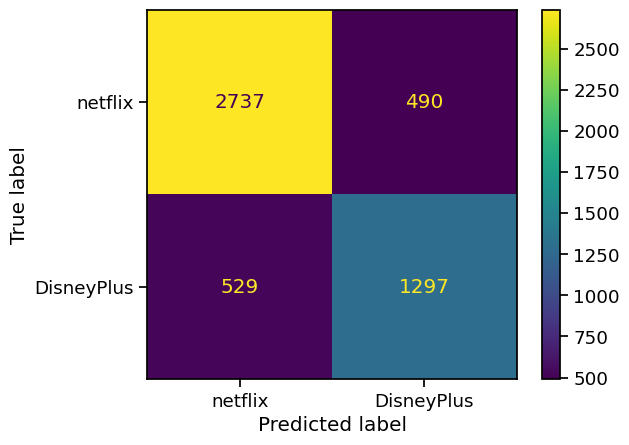

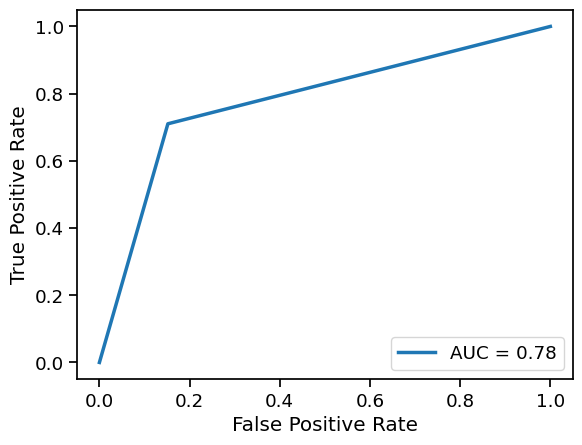

In [75]:
display_scores(gs2,X_train,y_train,X_test,y_test)

***Augmented(2) self text***

In [76]:
%%time
pipe_tvec_aug1 = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('nb', MultinomialNB())
                    ])

pipe_tvec_NB_aug1_params = {
    'tvec__max_features': [10_000,20_000,30_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words' : [New_stopwords],
    'nb__fit_prior': [True,False]
    }

gs2aug1 = GridSearchCV(pipe_tvec_aug1, 
                  param_grid=pipe_tvec_NB_aug1_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=10,
                  scoring = 'f1'
                 ).fit(X_train_aug5_df, y_train)

pd.DataFrame(gs2aug1.cv_results_)[['param_tvec__max_df', 'param_tvec__max_features', 'param_tvec__min_df','param_tvec__ngram_range'
                               , 'param_nb__fit_prior','mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: total: 16.6 s
Wall time: 3min 25s


,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_nb__fit_prior,mean_test_score,rank_test_score
24,0.9,10000,2,"(1, 1)",False,0.706661,1
36,0.95,10000,2,"(1, 1)",False,0.706661,1


Accuracy_score(train):0.72
Accuracy_score(test):0.80
MisclassificationRate_score(test):0.20
Recall_score(test):0.71
Specificity_score(test):0.85
Precision_score(test):0.73
F1_score(test):0.72
ROC_AUC_score(test):0.78


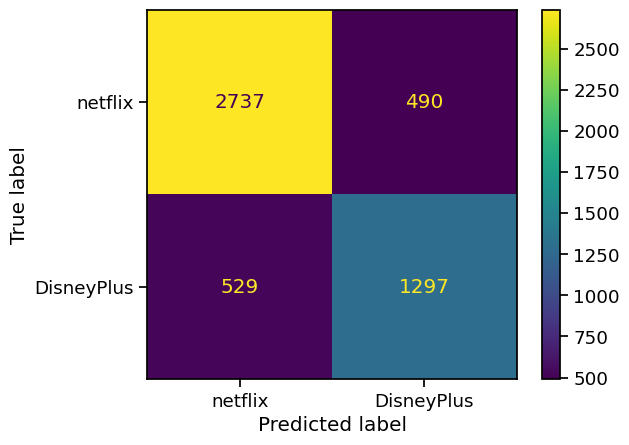

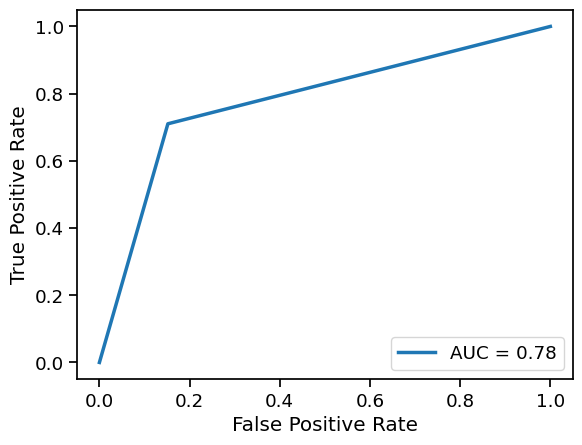

In [77]:
display_scores(gs2,X_train_aug5_df,y_train,X_test,y_test)

#### Model 3 Log Regression Model + TFIDF vectorizer

In [80]:
%%time
pipe_tvec_lr = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('logreg',  LogisticRegression())
                    ])

pipe_tvec_lr_params = {
                        'tvec__max_features': [20_000],
                        'tvec__min_df': [3],
                        'tvec__max_df': [.9],
                        'tvec__ngram_range': [(1,1)],
                        'tvec__stop_words' : [New_stopwords],
                        'logreg__C': np.linspace(1, 10, 10),# checking C parameter
                        'logreg__penalty':['l1','l2'],# checking penalty parameter
                        'logreg__n_jobs': [-1],
                        'logreg__solver': ['liblinear'],
                        }
gs3 = GridSearchCV(pipe_tvec_lr, 
                  param_grid=pipe_tvec_lr_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=10,
                  scoring = 'f1'
                 ).fit(X_train, y_train)

pd.DataFrame(gs3.cv_results_)[['param_logreg__C','param_logreg__penalty','param_logreg__solver',
                               'mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 1.08 s
Wall time: 11 s


C:\Users\zuans\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(


,param_logreg__C,param_logreg__penalty,param_logreg__solver,mean_test_score,rank_test_score
9,5.0,l2,liblinear,0.724070,1
11,6.0,l2,liblinear,0.722193,2


Accuracy_score(train):0.87
Accuracy_score(test):0.82
MisclassificationRate_score(test):0.18
Recall_score(test):0.69
Specificity_score(test):0.89
Precision_score(test):0.78
F1_score(test):0.73
ROC_AUC_score(test):0.79


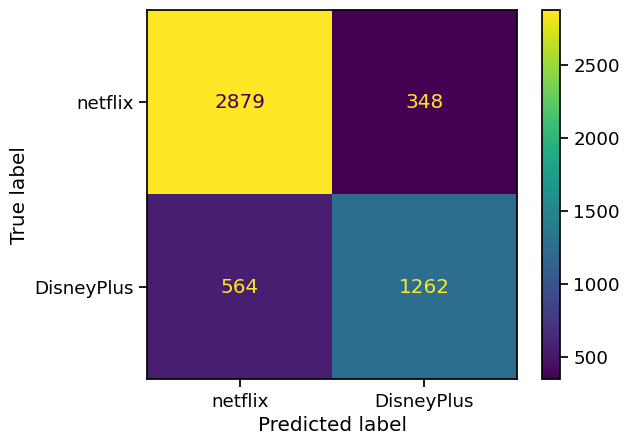

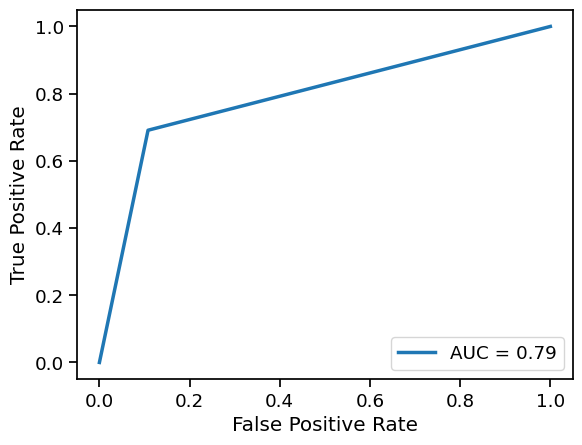

In [81]:
display_scores(gs3,X_train,y_train,X_test,y_test)

#### Model 4 SGDClassifier Model + TFIDF vectorizer

In [82]:
%%time
pipe_tvec_sgd = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('sgd',  SGDClassifier())
                    ])

pipe_tvec_sgd_params = {
                        'tvec__max_features': [20_000],
                        'tvec__min_df': [3],
                        'tvec__max_df': [.9],
                        'tvec__ngram_range': [(1,1)],
                        'tvec__stop_words' : [New_stopwords],
                        # 'sgd__alpha': [0.0001,0.001], # checking Alpha
                        # 'sgd__average': [True,False], # checking to use average
                        # 'sgd__loss': ['hinge', 'log_loss', 'log', 'squared_hinge', 'perceptron', 'squared_error', 
                        #               'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], # checking loss function
                        'sgd__alpha': np.linspace(0.0001, 0.001, 5), # After hyperparameter tuning
                        'sgd__n_iter_no_change': [2],
                        'sgd__n_jobs': [-1],

                        }

gs4= GridSearchCV(pipe_tvec_sgd, 
                  pipe_tvec_sgd_params,
                  cv=2,
                  verbose = 1,
                  n_jobs=-1
                 ).fit(X_train, y_train)

pd.DataFrame(gs4.cv_results_)[['param_sgd__alpha',
                               'mean_test_score','rank_test_score'
                              ]].sort_values('rank_test_score').head(2)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
CPU times: total: 578 ms
Wall time: 4.37 s


,param_sgd__alpha,mean_test_score,rank_test_score
0,0.0001,0.795554,1
1,0.000325,0.786581,2


Accuracy_score(train):0.88
Accuracy_score(test):0.81
MisclassificationRate_score(test):0.19
Recall_score(test):0.64
Specificity_score(test):0.91
Precision_score(test):0.81
F1_score(test):0.71
ROC_AUC_score(test):0.78


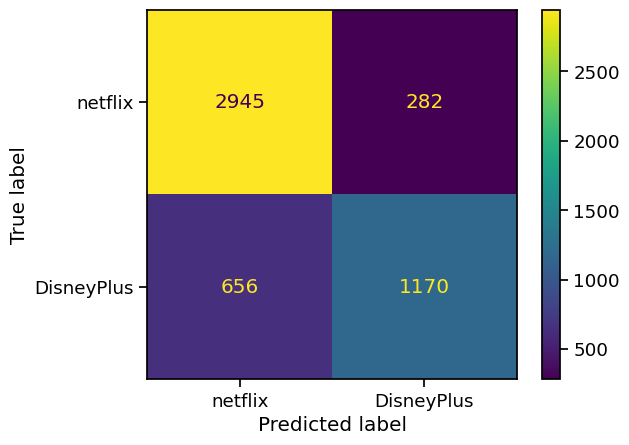

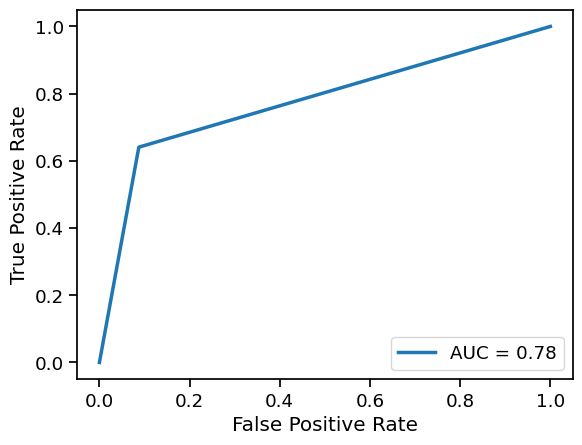

In [85]:
display_scores(gs4,X_train,y_train,X_test,y_test)

#### Model 5 Decision Tree Model + TFIDF vectorizer

In [119]:
%%time
pipe_tvec_dtc = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('dtc',  DecisionTreeClassifier())
                    ])

pipe_tvec_dtc_params = {
                        'tvec__max_features': [20_000],
                        'tvec__min_df': [3],
                        'tvec__max_df': [.9],
                        'tvec__ngram_range': [(1,1)],
                        'tvec__stop_words' : [New_stopwords],
    
                        'dtc__max_depth': [10,13,15], # Checking Max depth
                        'dtc__min_samples_leaf': [2,4,6], # Checking min samples leaf
                        'dtc__min_samples_split': [2,5,10,15],# Checking min samples split
                        # 'dtc__ccp_alpha': np.linspace(0, 0.001, 10),# Checking alpha
                        }

gs5= GridSearchCV(pipe_tvec_dtc, 
                  pipe_tvec_dtc_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring ='f1'
                 ).fit(X_train, y_train)

pd.DataFrame(gs5.cv_results_)[['param_dtc__max_depth','param_dtc__min_samples_leaf','param_dtc__min_samples_split',
                               'mean_test_score','rank_test_score'
                              ]].sort_values('rank_test_score').head(2)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 4.22 s
Wall time: 22.5 s


,param_dtc__max_depth,param_dtc__min_samples_leaf,param_dtc__min_samples_split,mean_test_score,rank_test_score
26,15,2,10,0.436374,1
27,15,2,15,0.436325,2


Accuracy_score(train):0.64
Accuracy_score(test):0.68
MisclassificationRate_score(test):0.32
Recall_score(test):0.62
Specificity_score(test):0.71
Precision_score(test):0.55
F1_score(test):0.58
ROC_AUC_score(test):0.67


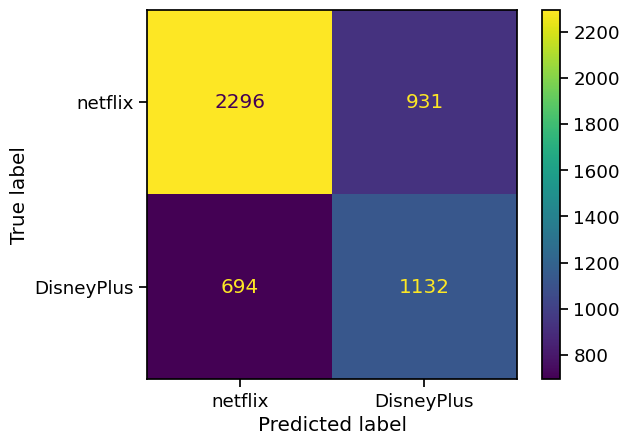

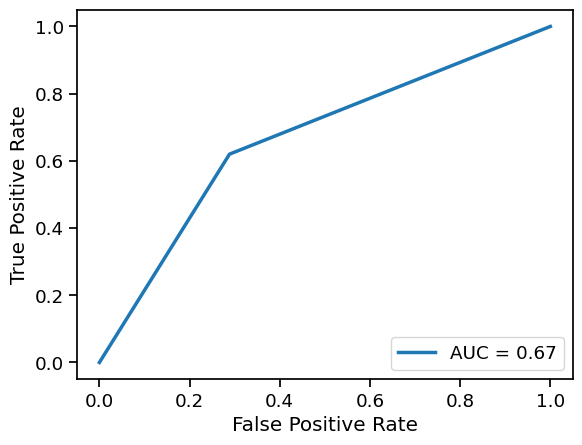

In [120]:
display_scores(gs5,X_train,y_train,X_test,y_test)

#### Model 6 Random Forest Model + TFIDF vectorizer

In [137]:
%%time
pipe_tvec_rfm = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('rfm',  RandomForestClassifier())
                    ])

pipe_tvec_rfm_params = {
                        'tvec__max_features': [20_000],
                        'tvec__min_df': [3],
                        'tvec__max_df': [.9],
                        'tvec__ngram_range': [(1,1)],
                        'tvec__stop_words' : [New_stopwords],
                        'rfm__n_jobs': [-1],
    
                        # 'rfm__class_weight':[{0:1,1:1},{0:1,1:4},{0:1,1:8}],# improving recall score
                        # 'rfm__min_samples_split':[2,3,4],# improving recall score

                        'rfm__class_weight':[{0:1,1:8}],# after hyper parameter tuning
                        'rfm__min_samples_split':[4],# after hyper parameter tuning

                        }

                        
gs6= GridSearchCV(pipe_tvec_rfm, 
                  pipe_tvec_rfm_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring='f1',# change to F1 scoring instead of accuracy
                 ).fit(X_train, y_train)

pd.DataFrame(gs6.cv_results_)[['param_rfm__class_weight','param_rfm__min_samples_split',
                               # 'param_rfm__max_depth',,'param_rfm__min_samples_leaf',
                               'mean_test_score','rank_test_score'
                              ]].sort_values('rank_test_score')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 35.8 s
Wall time: 10.7 s


,param_rfm__class_weight,param_rfm__min_samples_split,mean_test_score,rank_test_score
0,"{0: 1, 1: 8}",4,0.678542,1


Accuracy_score(train):0.99
Accuracy_score(test):0.76
MisclassificationRate_score(test):0.24
Recall_score(test):0.71
Specificity_score(test):0.79
Precision_score(test):0.66
F1_score(test):0.68
ROC_AUC_score(test):0.75


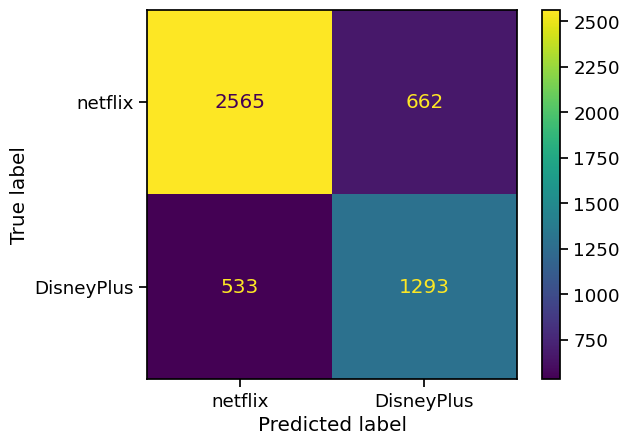

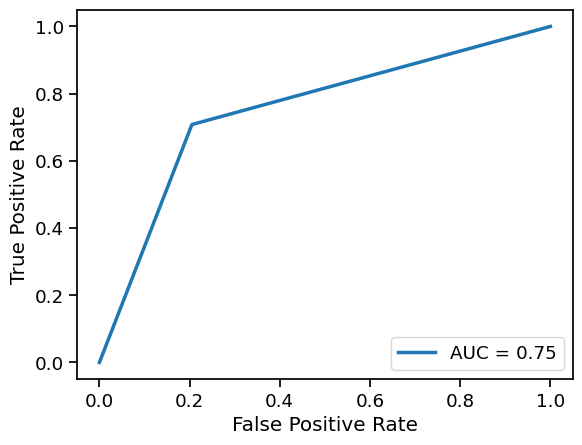

In [138]:
display_scores(gs6,X_train,y_train,X_test,y_test)

#### Model 7 Support Vector Machine Model + TFIDF vectorizer

In [20]:
%%time
pipe_tvec_svm = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('svm',  SVC())
                    ])

pipe_tvec_svm_params = {
                        'tvec__max_features': [20_000],
                        'tvec__min_df': [3],
                        'tvec__max_df': [.9],
                        'tvec__ngram_range': [(1,1)],
                        'tvec__stop_words' : [New_stopwords],
    
                        # 'svm__C': np.linspace(1, 1.5, 5), # Checking C
                        # 'svm__class_weight': ['balanced',None],# Checking class weight
                        # 'svm__gamma': ['scale','auto'],# Checking gamma
    
                        'svm__C': np.linspace(0.5, 1.5, 5), # after hyper parameter tuning
                        'svm__class_weight': ['balanced'],# after hyper parameter tuning
                        'svm__gamma': ['scale'],# after hyper parameter tuning
                        }

gs7= GridSearchCV(pipe_tvec_svm, 
                  pipe_tvec_svm_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1,
                  scoring='f1',# change to F1 scoring instead of accuracy
                 ).fit(X_train, y_train)

pd.DataFrame(gs7.cv_results_)[['param_svm__C','param_svm__class_weight','param_svm__gamma',
                               'mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(10)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 51.6 s
Wall time: 4min 32s


,param_svm__C,param_svm__class_weight,param_svm__gamma,mean_test_score,rank_test_score
4,1.5,balanced,scale,0.741748,1
3,1.25,balanced,scale,0.741680,2
2,1.0,balanced,scale,0.740730,3
1,0.75,balanced,scale,0.737740,4
0,0.5,balanced,scale,0.727828,5


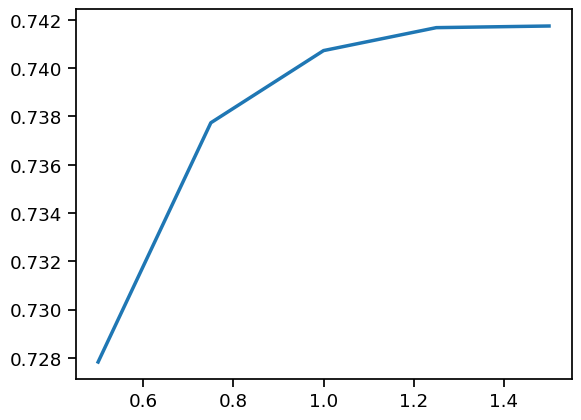

In [21]:
plt.plot("param_svm__C", "mean_test_score", data = pd.DataFrame(gs7.cv_results_)[['param_svm__C',
                               'mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(10));

Accuracy_score(train):0.99
Accuracy_score(test):0.83
MisclassificationRate_score(test):0.17
Recall_score(test):0.72
Specificity_score(test):0.89
Precision_score(test):0.78
F1_score(test):0.75
ROC_AUC_score(test):0.80


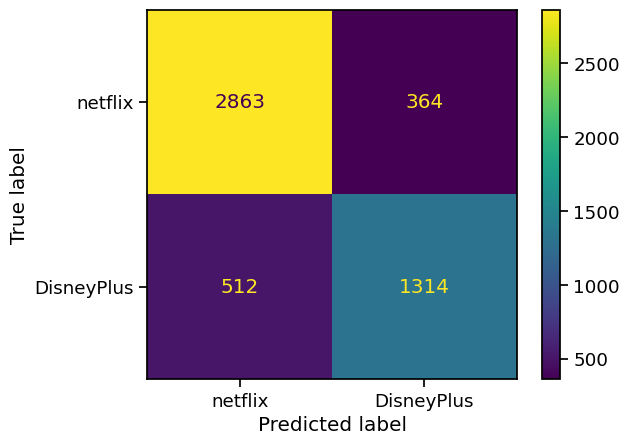

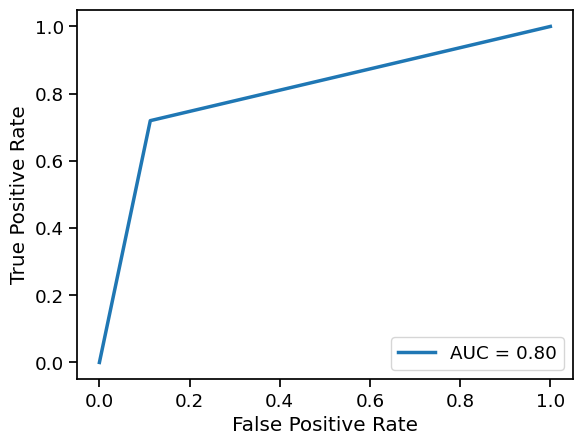

In [22]:
display_scores(gs7,X_train,y_train,X_test,y_test)

#### Model 8 Support Vector Machine Model + TfidfVectorizer with selftext + title

In [89]:
# combine self text with post title
X8 = post_df['selftext']+' '+post_df['title']
y8 = post_df['subreddit'].replace({'netflix': 0 ,'DisneyPlus': 1} )
X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y8, test_size=0.25, random_state=42, stratify=y)
y8.value_counts(normalize=True)

0    0.638712
1    0.361288
Name: subreddit, dtype: float64

In [25]:
%%time
pipe_tvec_svm2 = Pipeline([  
                    ('tvec', TfidfVectorizer()),
                    ('svm',  SVC())
                           ])

pipe_tvec_svm_params2 = {
                        'tvec__max_features': [20_000],
                        'tvec__min_df': [3],
                        'tvec__max_df': [.9],
                        'tvec__ngram_range': [(1,1)],
                        'tvec__stop_words' : [New_stopwords],
                        'svm__C': np.linspace(1, 1.5, 5),
                        'svm__class_weight': ['balanced']
                            }

gs8= GridSearchCV(pipe_tvec_svm2, 
                  pipe_tvec_svm_params2,
                  cv=2,
                  verbose = 1,
                  n_jobs=-1 ,
                  scoring='f1',# change to F1 scoring instead of accuracy
                 ).fit(X8_train, y8_train)

pd.DataFrame(gs8.cv_results_)[['param_svm__C',
                               'mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(10)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
CPU times: total: 55.8 s
Wall time: 2min 1s


,param_svm__C,mean_test_score,rank_test_score
3,1.375,0.755838,1
2,1.25,0.755183,2
4,1.5,0.754364,3
1,1.125,0.754209,4
0,1.0,0.753910,5


Accuracy_score(train):0.99
Accuracy_score(test):0.85
MisclassificationRate_score(test):0.15
Recall_score(test):0.75
Specificity_score(test):0.91
Precision_score(test):0.83
F1_score(test):0.79
ROC_AUC_score(test):0.83


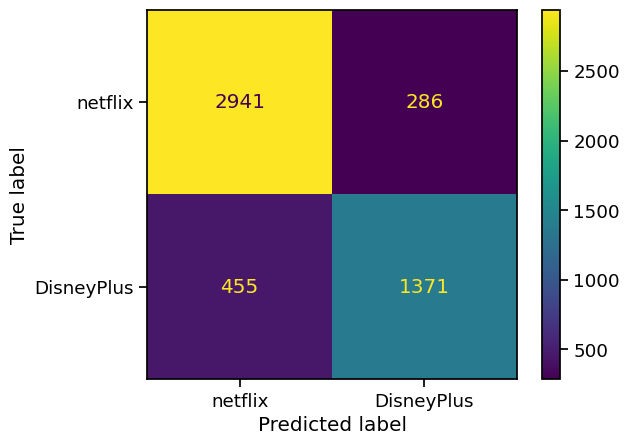

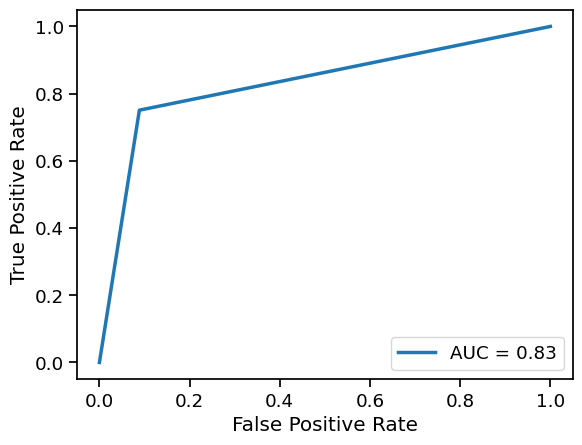

In [28]:
display_scores(gs8,X8_train,y8_train,X8_test,y8_test)

#### Model 9 pre-train bert model for preprocessing + neural network

In [28]:
# Download two pre trained BERT models for preprocessing and encoding.
bert_preprocess = hub.KerasLayer("http://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/google/experts/bert/wiki_books/sst2/2")

***Functional model***

In [29]:
# initializing the BERT layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # creating an input layer with bert_preprocess()
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)# convert the preprocessed text into embedding vectors

# initializing the neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) # prevent model from overfitting
l = tf.keras.layers.Dense(1, activation='sigmoid')(l) # sigmoid is used when we have output values that between 0 and 1

model9 = tf.keras.Model(inputs=[text_input], outputs = [l])

model9.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [30]:
# Model compiling
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

adamax = Adamax(
                learning_rate=0.01,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07
                )
model9.compile(optimizer=adamax,
 loss='binary_crossentropy',
 metrics=METRICS)

In [31]:
# Model fiting
model9.fit(X8_train, y8_train, epochs=10)

Epoch 1/10
474/474 [==============================] - 172s 352ms/step - loss: 0.4391 - accuracy: 0.7955 - precision: 0.7690 - recall: 0.6202
Epoch 2/10
474/474 [==============================] - 167s 352ms/step - loss: 0.3766 - accuracy: 0.8339 - precision: 0.8093 - recall: 0.7069
Epoch 3/10
474/474 [==============================] - 167s 351ms/step - loss: 0.3643 - accuracy: 0.8401 - precision: 0.8116 - recall: 0.7259
Epoch 4/10
474/474 [==============================] - 168s 354ms/step - loss: 0.3602 - accuracy: 0.8388 - precision: 0.8075 - recall: 0.7272
Epoch 5/10
474/474 [==============================] - 167s 352ms/step - loss: 0.3584 - accuracy: 0.8412 - precision: 0.8111 - recall: 0.7306
Epoch 6/10
474/474 [==============================] - 167s 352ms/step - loss: 0.3615 - accuracy: 0.8411 - precision: 0.8079 - recall: 0.7348
Epoch 7/10
474/474 [==============================] - 167s 353ms/step - loss: 0.3538 - accuracy: 0.8440 - precision: 0.8132 - recall: 0.7376
Epoch 8/10
47

158/158 [==============================] - 57s 357ms/step
Accuracy_score(test):0.82
MisclassificationRate_score(test):0.18
Recall_score(test):0.61
Specificity_score(test):0.94
Precision_score(test):0.85
F1_score(test):0.71
ROC_AUC_score(test):0.78


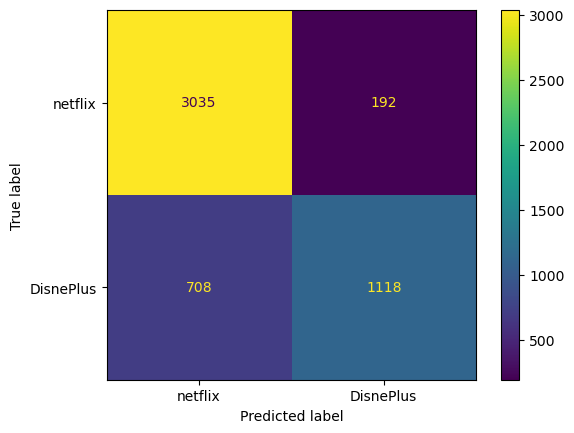

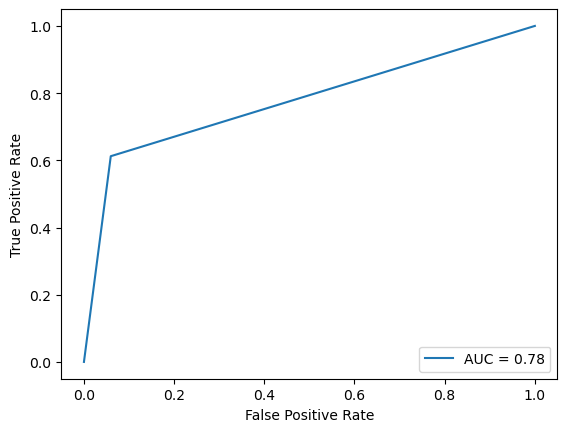

In [32]:
# Get scores
y_predicted = model9.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['netflix', 'DisnePlus'])
disp.plot();

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot();

tn, fp, fn, tp = cm.ravel()
# print(f'Accuracy_score(train):{model12.score(X_train,y_train):0.2f}')
print(f'Accuracy_score(test):{(tp+tn)/(tp+fn+fp+tn):0.2f}')
print(f'MisclassificationRate_score(test):{1-((tp+tn)/(tp+fn+fp+tn)):0.2f}')
print(f'Recall_score(test):{tp/(fn+tp):0.2f}') 
print(f'Specificity_score(test):{tn/(fp+tn):0.2f}') 
print(f'Precision_score(test):{tp/(tp+fp):0.2f}') 
print(f'F1_score(test):{f1_score(y_test, y_predicted):0.2f}')
print(f'ROC_AUC_score(test):{roc_auc:0.2f}')

#### Model 10 LGBM Model

In [96]:
%%time
pipe_tvec_lgb = Pipeline([  
                    ('tvec', TfidfVectorizer()),
                    ('lgm',  LGBMClassifier(device='gpu',
                                                   n_jobs=-1,
                                                   silent='warn'))
                           ])
pipe_tvec_lgb_params = {
                        'tvec__max_features': [20_000],
                        'tvec__min_df': [3],
                        'tvec__max_df': [.9],
                        'tvec__ngram_range': [(1,1)],
                        'tvec__stop_words' : [New_stopwords],
                        'lgm__max_depth': [-1,0],
                        'lgm__min_child_samples': [5,20,50,100],
                        'lgm__num_leaves': [5,31,62,100],
                        'lgm__reg_alpha': [0.0,0.5,1],
                        'lgm__reg_lambda': [0.0,0.5,1]
                        }

gs10= GridSearchCV(pipe_tvec_lgb, 
                  pipe_tvec_lgb_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=-1 ,
                  scoring='f1',# change to F1 scoring instead of accuracy
                 ).fit(X8_train, y8_train)

pd.DataFrame(gs10.cv_results_)[['param_lgm__max_depth','param_lgm__min_child_samples','param_lgm__num_leaves',
                                'param_lgm__reg_alpha','param_lgm__reg_lambda',
                               'mean_test_score', 'rank_test_score'
                              ]].sort_values('rank_test_score').head(10)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 21.9min finished


Wall time: 21min 58s


,param_lgm__max_depth,param_lgm__min_child_samples,param_lgm__num_leaves,param_lgm__reg_alpha,param_lgm__reg_lambda,mean_test_score,rank_test_score
172,0,5,100,0.0,0.5,0.749652,1
28,-1,5,100,0.0,0.5,0.749652,1
27,-1,5,100,0.0,0.0,0.749206,3
171,0,5,100,0.0,0.0,0.749206,3
173,0,5,100,0.0,1,0.745319,5
29,-1,5,100,0.0,1,0.745319,5
163,0,5,62,0.0,0.5,0.744407,7
19,-1,5,62,0.0,0.5,0.744407,7
174,0,5,100,0.5,0.0,0.743280,9
30,-1,5,100,0.5,0.0,0.743280,9


Accuracy_score(train):0.96
Accuracy_score(test):0.83
MisclassificationRate_score(test):0.17
Recall_score(test):0.70
Specificity_score(test):0.91
Precision_score(test):0.81
F1_score(test):0.75
ROC_AUC_score(test):0.80


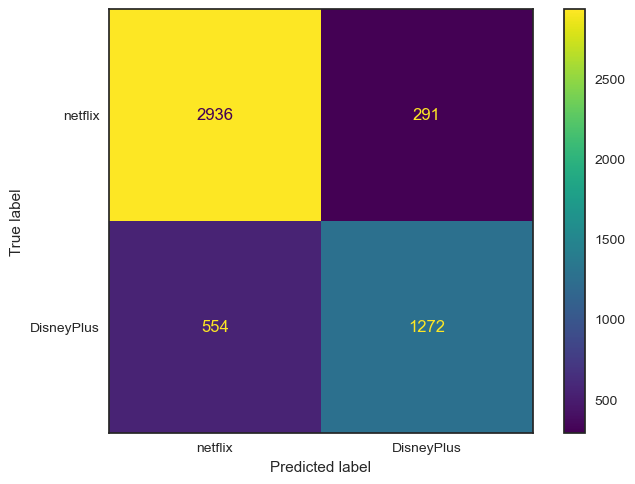

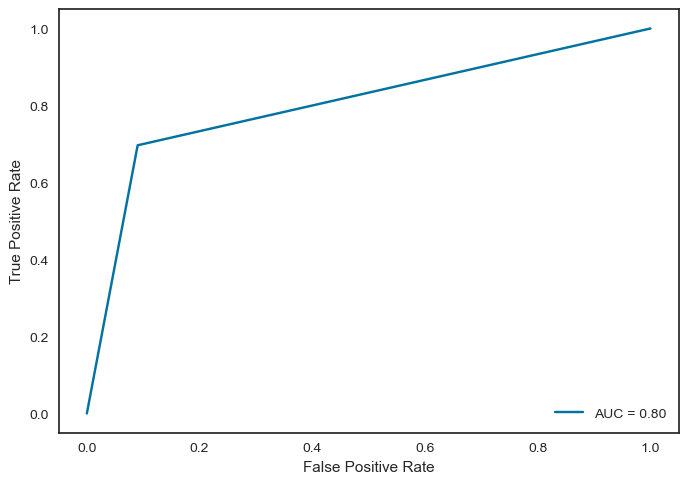

In [97]:
display_scores(gs10,X8_train,y8_train,X8_test,y8_test)

#### Zero shot classification by hugging face

In [ ]:
# Instantiate classifier pipline
classifier = pipeline("zero-shot-classification", model="typeform/distilbert-base-uncased-mnli")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [28]:
# make prediction using zero shot classification
class_lis = []
candidate_labels = ['netflix', 'disneyplus']
for sentence in tqdm(X, desc = 'tqdm() Progress Bar',mininterval =1):
        dic = classifier(sentence, candidate_labels, multi_label=True)
        class_lis.append(dic['labels'][0])

tqdm() Progress Bar: 100%|██████████| 20134/20134 [28:36<00:00, 11.73it/s]


In [41]:
# make dataframe for results
zero_shot_df = pd.DataFrame(class_lis, columns= ['zero_shot'])
zero_shot_df = zero_shot_df.replace({'netflix': 0 ,'disneyplus': 1} )

Accuracy_score(test):0.76
MisclassificationRate_score(test):0.24
Recall_score(test):0.55
Specificity_score(test):0.87
Precision_score(test):0.71
F1_score(test):0.62
ROC_AUC_score(test):0.71


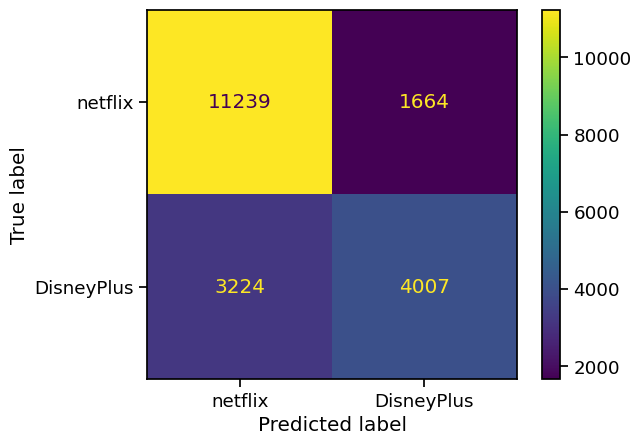

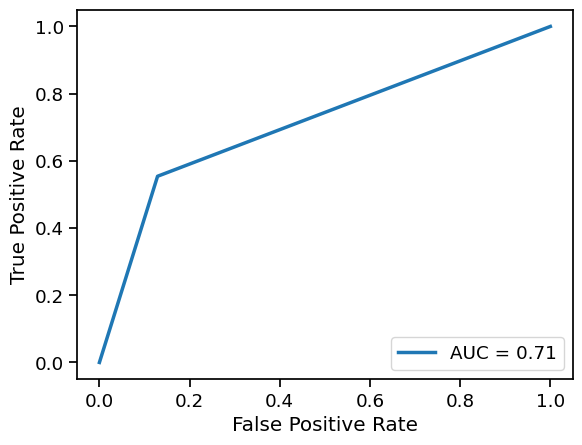

In [42]:
# Get scores
cm2 = confusion_matrix(y, zero_shot_df)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['netflix', 'DisneyPlus'])
disp2.plot();

fpr2, tpr2, thresholds2 = metrics.roc_curve(y, zero_shot_df)
roc_auc2 = metrics.auc(fpr2, tpr2)
display2 = metrics.RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=roc_auc2)
display2.plot();

tn2, fp2, fn2, tp2 = cm2.ravel()
# print(f'Accuracy_score(train):{model12.score(X_train,y_train):0.2f}')
print(f'Accuracy_score(test):{(tp2+tn2)/(tp2+fn2+fp2+tn2):0.2f}')
print(f'MisclassificationRate_score(test):{1-((tp2+tn2)/(tp2+fn2+fp2+tn2)):0.2f}')
print(f'Recall_score(test):{tp2/(fn2+tp2):0.2f}') 
print(f'Specificity_score(test):{tn2/(fp2+tn2):0.2f}') 
print(f'Precision_score(test):{tp2/(tp2+fp2):0.2f}') 
print(f'F1_score(test):{f1_score(y, zero_shot_df):0.2f}')
print(f'ROC_AUC_score(test):{roc_auc2:0.2f}')

## Model summary and evaluation(top 5)

- **Comparision between normal text vs Augmented Synonym text 1 vs Augmented Synonym text 2**
Score|NB Cvec	|NB Cvec Aug1	|NB Cvec Aug2
---|---|---|---
Acc (train)	|0.83	|0.78	|0.78
Acc (test)	0.81	|0.78	|0.78
Recall (test)	|0.67	|0.73	|0.73
Spec (test)	|0.89	|0.82	|0.81
Prec (test)	|0.77	|0.69	|0.68
F1 (test)	|0.71	|0.71	|0.71
AUC (test)	|0.78	|0.77	|0.77

- test metric scores are quite similar except specificity is higher when using normal text is higher
- Better at predicting True Negative with normal text as feature
---
**Count vs TFIDF Vectorizer**

Score|	NB Cvec	|NB Tvec
---|---|---
Acc (train)|	0.83	|0.79
Acc (test)|	0.81	|0.80
Recall (test)|	0.67	|0.71
Spec (test)|	0.89	|0.85
Prec (test)|	0.77	|0.73
F1 (test)|	0.71	|0.72
AUC (test)|	0.78	|0.78

- Both vectorizer methods yield similar test metric scores with Tf Idf method having a slight advantage for recall 
---
**Scores normal text vs Augmented Synonym text 2**

Score|	NB Tvec	|NB Tvec Aug2
---|---|---
Acc (train)|	0.79|	0.72
Acc (test)|	0.80|	0.80
Recall (test)|	0.71|	0.71
Spec (test)|	0.85|	0.85
Prec (test)|	0.73|	0.73
F1 (test)|	0.72|	0.72
AUC (test)|	0.78|	0.78

- for Tf Idf vectorizer method augmented sentance have no effect.

In [8]:
scores_df= pd.read_csv('scores.txt',sep ='\t').set_index('Score')
scores_df.T.sort_values('Acc (test)',ascending =False)

Score,Acc (train),Acc (test),Recall (test),Spec (test),Prec (test),F1 (test),AUC (test)
SVM Tvec (selftext + title),0.99,0.85,0.75,0.91,0.83,0.79,0.83
SVM Tvec,0.99,0.83,0.72,0.89,0.78,0.75,0.80
LBM,0.96,0.83,0.70,0.91,0.81,0.75,0.80
LR Tvec,0.87,0.82,0.69,0.89,0.78,0.73,0.79
BERT Preprocess / Encoding + NN,0.83,0.82,0.61,0.94,0.85,0.71,0.78
NB Cvec,0.83,0.81,0.67,0.89,0.77,0.71,0.78
SGD Tvec,0.91,0.81,0.59,0.93,0.84,0.69,0.76
NB Tvec,0.79,0.80,0.71,0.85,0.73,0.72,0.78
NB Tvec Aug2,0.72,0.80,0.71,0.85,0.73,0.72,0.78
NB Cvec Aug1,0.78,0.78,0.73,0.82,0.69,0.71,0.77


**Top 5 models**
1) Support Vector Machine model with TfIdf Vectorizer using selftext and title for features
1) Support Vector Machine model with TfIdf Vectorizer using selftext for feature
1) Light Gradient Boosting model with TfIdf Vectorizer using selftext and title for features
1) Linear Regression model with TfIdf Vectorizer using selftext for featureusing selftext for feature
1) Neural Networks with BERT preprocessing using selftext and title for features

In [6]:
def get_plots(df):
    sns.set(rc={'figure.figsize':(8,5)})
    ax = df.plot(style="*", ms=10,colormap = 'Dark2')
    ax.legend(loc='best', bbox_to_anchor=(1,1));
    for num in (range(len(df.columns))):
        ax.lines[num].set_linestyle(" ")

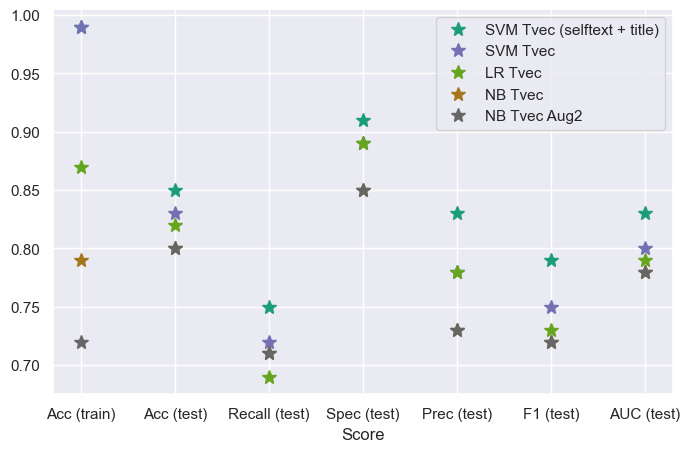

In [9]:
get_plots(scores_df[['SVM Tvec (selftext + title)', 'SVM Tvec ', 'LR Tvec', 'NB Tvec',
       'NB Tvec Aug2']])

## Data Visualization

### Emotional analysis with roberta and Non-Negative Matrix Factorization 

In [ ]:
# Instantiate classifier pipeline
classifier2 = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base",truncation=True)

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

C:\Users\zuans\.conda\envs\dsi-sg32\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zuans\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [63]:
# using classifier to classify emotions of the post
emo_lis = []
for sentence in tqdm(X, desc = 'tqdm() Progress Bar',mininterval =1):
        emo_lis.append(classifier(sentence)[0]['label'])

tqdm() Progress Bar: 100%|██████████| 20223/20223 [14:54<00:00, 22.60it/s]


In [244]:
# make data frame for emotional prediction
emo = pd.DataFrame(y.replace({0 : 'netflix', 1 : 'DisneyPlus'} ))
emo['Emotion'] = emo_lis
emo_text = pd.concat([emo,post_df['selftext']],ignore_index=True,axis=1).rename(columns={0:'subreddit', 1:'emotion', 2:'post'})

In [62]:
append_stoplist = New_stopwords + ['watch','amp','maybe', 'just']

In [63]:
# Function for topic extraction with Non-negative Matrix Factorization
def get_topicwords(subreddit,emotion):
    tfidf_vectorizer = TfidfVectorizer(stop_words=append_stoplist , ngram_range=(2,2), 
                                        max_df=0.98,min_df=3, max_features=20_000)
    nmf = NMF(n_components=1,max_iter=1000)
    pipe = Pipeline(tfidf_vectorizer, nmf)
    pipe.fit(emo_text[(emo_text['subreddit']==subreddit) & (emo_text['emotion']==emotion)]['post'])
    print_top_words(nmf, tfidf_vectorizer.get_feature_names_out(), n_top_words=10)

In [600]:
# Function to print topic words from Non-negative Matrix Factorization model predictions
def print_top_words(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            message = "Topic #%d: " % topic_idx
            message += ", ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])
            print(message)
        print()

##### 1) Sentiment analysis for Netflix

Focusing on extreme negative sentiments anger and disgust, we can deduce that users are feeling annoyed at the streaming service or the casting choice of the show.

1) Surprised 😲
    - Topic subject: *width format, format auto ,xb preview*

1) Sadness 😭
    - Topic subject: *main character, stranger thing, breaking bad*

1) Joy 😀
    - Topic adjectives: *really enjoyed,really good*
    - Topic subject: *umbrella academy, streaming service, sci fi, sex education,stranger thing, breaking bad* 

1) Anger 🤬
    - Topic adjectives: *really annoying, super annoying*
    - Topic words: *streaming service, new episode*

1) Fear 😨
    - Topic adjectives: *good horror, jump scare, like horror*
    - Topic subject: *horror movie*

1) Disgust 🤢
    - Topic subject: *old girl, streaming service, young girl, sci fi*

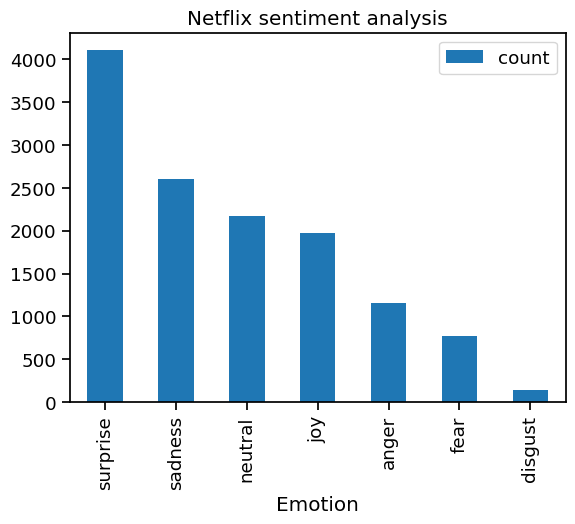

In [369]:
netflix_emo = pd.DataFrame(emo[emo['subreddit'] == 'netflix'].value_counts(), columns=['count']).reset_index().drop(['subreddit'],axis =1)
netflix_emo.plot.bar(x='Emotion', y='count', rot=90)
plt.title('Netflix sentiment analysis');

In [640]:
get_topicwords('netflix','joy')

Topic #0: feel like, really enjoyed, stranger thing, breaking bad, umbrella academy, really good, finished watching, streaming service, sci fi, sex education



In [641]:
get_topicwords('netflix','surprise')

Topic #0: doe know, width format, preview redd, auto webp, format auto, started watching, hey guy, xb preview, continue watching, year ago



In [642]:
get_topicwords('netflix','neutral')

Topic #0: reddit poll, view poll, poll reddit, removed view, breaking bad, good movie, tv series, best friend, know people, want know



In [643]:
get_topicwords('netflix','sadness')

Topic #0: feel like, doe know, main character, stranger thing, series feel, breaking bad, continue watching, looking forward, like people, title say



In [644]:
get_topicwords('netflix','fear')

Topic #0: horror movie, good horror, year old, like horror, movie watched, movie like, movie series, movie make, jump scare, time try



In [645]:
get_topicwords('netflix','disgust')

Topic #0: year old, old girl, streaming service, people think, feel like, felt like, like people, young girl, sci fi, look like



In [646]:
get_topicwords('netflix','anger')

Topic #0: feel like, really annoying, year old, streaming service, look like, anybody feel, super annoying, new episode, feel free, want know



##### 2) Sentiment analysis for DisneyPlus

Taking only extreme negative sentiments anger and disgust we can infer that users are annoyed with the streaming service or movies they were watching.

1) Surprised 😲
    - Topic adjectives: *having problem*
    - Topic subject: *star war, spider man, streaming service,marvel cartoon*
    
    
2) Sadness 😭

      - Topic subject: *credit card, movie series, star war, season available*

3) Joy 😀

    - Topic subject: *reddit comment, subreddit member, ask recommendation, thread reddit, discussion thread*

4) Fear 😨

    - Topic adjectives: *good horror, jump scare, like horror*

    - Topic subject: *american horror, horror story*

5) Disgust 🤢

Topic subject: *streaming service*

6) Anger 🤬

      - Topic adjectives: *really annoying*

      - Topic words: *episode episode, movie french, star war, streaming service, marvel star*

Text(0.5, 1.0, 'Disneyplus sentiment analysis')

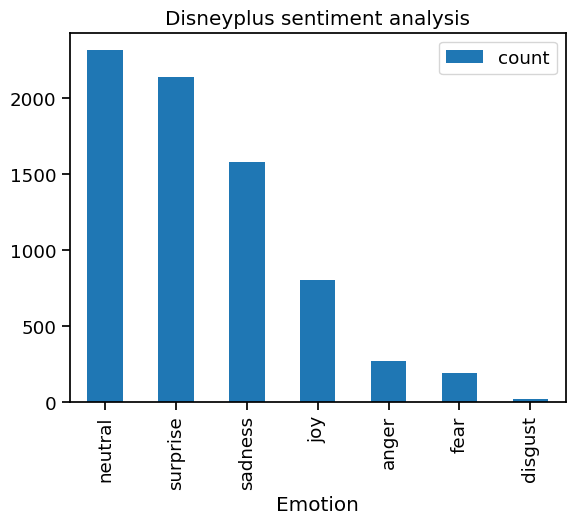

In [397]:
disneyplus_emo = pd.DataFrame(emo[emo['subreddit'] == 'DisneyPlus'].value_counts(), columns=['count']).reset_index().drop(['subreddit'],axis =1)
disneyplus_emo.plot.bar(x='Emotion', y='count', rot=90)
plt.title('Disneyplus sentiment analysis')

In [625]:
get_topicwords('DisneyPlus','joy')

Topic #0: spoiler tag, reddit comment, feel free, try avoid, subreddit member, ask recommendation, thread reddit, discord gg, discussion thread, comment duvyvj



In [626]:
get_topicwords('DisneyPlus','surprise')

Topic #0: doe know, star war, spider man, know going, streaming service, know happened, continue watching, movie available, marvel cartoon, having problem



In [631]:
get_topicwords('DisneyPlus','neutral')

Topic #0: reddit poll, view poll, poll reddit, removed view, title view, premier access, animated series, added app, guy think, second season



In [627]:
get_topicwords('DisneyPlus','sadness')

Topic #0: doe know, feel like, know fix, credit card, movie series, really want, know available, star war, year old, season available



In [628]:
get_topicwords('DisneyPlus','fear')

Topic #0: american horror, horror story, season american, continue watching, season episode, pjpg auto, width format, preview redd, auto webp, jpg width



In [629]:
get_topicwords('DisneyPlus','disgust')

Topic #0: streaming service



In [630]:
get_topicwords('DisneyPlus','anger')

Topic #0: doe know, episode episode, want know, movie french, star war, streaming service, feel like, really annoying, continue watching, marvel star



### Conclusion and Recommendation

Best model SVM model 8 with Seft text and title

- Accuracy_score(train):0.99
- Accuracy_score(test):0.85
- MisclassificationRate_score(test):0.15
- Recall_score(test):0.75
- Specificity_score(test):0.91
- Precision_score(test):0.83
- F1_score(test):0.79
- ROC_AUC_score(test):0.8

<img src="img/top5_model.png" width="500"><img src="img/model8_cm.png" width="500">
---

Sentiment analysis insights
- Suprise, sadness and Joy are the main top 3 emotions coming from users

<img src="img/disneyplus_sent.png" width="450"><img src="img/netlfix_sent.png" width="450">

**Recommendation**

With the data we have from sentiments analysis and topic words extraction, we are able to identify issues, concerns or suggestions that users posted. Prompted investigation or troubleshooting can be initiated to prevent long term disadvantages such as customers leaving, tarnish reputation or poor reviews.

This approch will able to improve efficiency and effectiveness of the service provider to customer relations as well as the product it self which will be in this case the streaming outlet.

Future implementations can include priortizing major issues, pick up trending shows where more similar shows can be streamed, or even sentiment analysis if each shows to gauge its money value to the streaming services